# Detecting faces in images with a Convolutional Neural Network (CNN)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
import numpy as np
from PIL import Image
from tqdm import tqdm
from nms import nms as nmsp
import os
import random
import cv2 # pip install opencv-python

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/Assignment2_data.zip" /content/data.zip
!unzip /content/data.zip -d /content/data/

# 1. Train a convolutional neural network for binary classification
The network will learn to classify 48x48 patches into two classes: noface/face.

In [5]:
transforms = ToTensor()
# Jupyter notebook local directories:
#train_root_dir = './Assignment2_data/train'
#val_root_dir = './Assignment2_data/val'

# Google colab directories:
train_root_dir = '/content/data/Assignment2_data/train'
val_root_dir = '/content/data/Assignment2_data/val'

# Create dataset objects
train_dataset = ImageFolder(train_root_dir, loader=Image.open, transform=transforms)
val_dataset = ImageFolder(val_root_dir, loader=Image.open, transform=transforms)

# Create dataloader objects
batch_size= 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# to get an overview
print(len(train_dataset))
print(len(val_dataset))

89340
10000


In [6]:
def print_samples(root_dir, label):
    '''Prints 4 random samples from the given root directory and chosen label (also directory)'''
    samples = []
    
    for index in range(4):
        random_sample = random.choice(os.listdir(root_dir + '/' + label + '/'))
        samples.append(random_sample)
        
    fig, axarr = plt.subplots(2,2)
    plt.suptitle(str(label), fontweight='bold', fontsize=16)
    [axi.set_axis_off() for axi in axarr.ravel()]  # turn axis off for all subplots
    
    image_1_1 = Image.open(root_dir + '/' + label + '/' + samples[0])
    axarr[0,0].imshow(image_1_1)
    axarr[0,0].set_title(str(samples[0]))
    
    image_1_2 = Image.open(root_dir + '/' + label + '/' + samples[1])
    axarr[0,1].imshow(image_1_2)
    axarr[0,1].set_title(str(samples[1]))

    image_1_3 = Image.open(root_dir + '/' + label + '/' + samples[2])
    axarr[1,0].imshow(image_1_3)
    axarr[1,0].set_title(str(samples[2]))
    
    image_1_4 = Image.open(root_dir + '/' + label + '/' + samples[3])
    axarr[1,1].imshow(image_1_4)
    axarr[1,1].set_title(str(samples[3]))

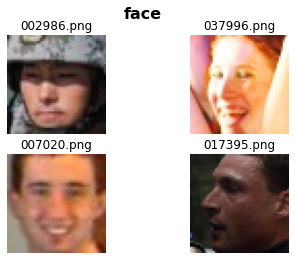

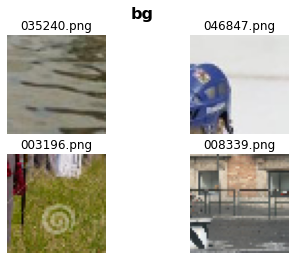

In [194]:
# Visualize a few images from both classes (face and bg)

print_samples(train_root_dir, 'face')
print_samples(train_root_dir, 'bg')

# could also visualize samples from the validation set, if desired
# print_samples(val_root_dir, 'face')
# print_samples(val_root_dir, 'bg')

In [9]:
# Implement a binary convolutional model

class ConvModel(nn.Module):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3x48x48 (3:rgb, 48:width, 48:height)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1)),
            # output: 32x46x46 (because kerne_size=3 and no padding)
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), ceil_mode=True),
            # output: 32x23x23 (note for myself: ceil_mode doesn't do padding on both sides!)
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            # output: 64x21x21
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            # output: 64x10x10
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            # output: 64x8x8
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            # output: 64x4x4
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(1,1)),
            # output: 128x3x3
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1)),
            # output: 256x1x1
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=(1,1), stride=(1,1))
            # output: 2x1x1
        )
        
    def forward(self, x):
        # as seen in tutorial:
        # no flattening here, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = self.conv_layers(x)
        return output

In [10]:
# Write the training code and train the network previously implemented

def train(model, train_dataloader, optimizer, loss_fn):
    """Training the given model with train dataloader for one epoch"""
    model.train()
    losses = []
    correct_classifications = 0
    
    for iteration, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        output = output.reshape(-1,2)  # reshape output for feeding it to cross entropy loss
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        # compute accuracy and loss for iteration
        losses.append(loss.item())
        correct_classifications += torch.sum(output.argmax(1) == labels).item()
    
    # compute accuracy of overall training
    accuracy = 100 * correct_classifications / len(train_dataloader.dataset)
    
    return np.mean(np.array(losses)), accuracy

In [11]:
def test(model, test_dataloader, loss_fn):
    """Testing the model with given test dataloader"""
    model.eval()
    
    test_loss, correct_classifications = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            output = output.reshape(-1,2)  # reshape output for feeding it to cross entropy loss
            loss = loss_fn(output, labels)
            
            test_loss += loss.item()
            correct_classifications += torch.sum(output.argmax(1) == labels).item()
    
    avg_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct_classifications / len(test_dataloader.dataset)
    
    return avg_loss, accuracy

In [13]:
def plot_metrics(n_epochs, losses_train, losses_val, accs_train, accs_val):
    """ This method plots the (avg) losses and the accuracy per epoch of the training set and the 
    validation set in the same subplot for direct comparison"""
    
    plt.figure(1, figsize=(15,4.5))
   
    plt.subplot(1,2,1)
    plt.scatter(np.arange(1, n_epochs+1), np.array(losses_train), label='Training')
    plt.scatter(np.arange(1, n_epochs+1), np.array(losses_val), label='Validation')
    plt.title("Average loss per epoch", y=-0.24, fontweight='bold', fontsize=13)
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.xticks(np.arange(1, n_epochs+1))
    
    plt.subplot(1,2,2)
    plt.scatter(np.arange(1, n_epochs+1), np.array(accs_train), label='Training')
    plt.scatter(np.arange(1, n_epochs+1), np.array(accs_val), label='Validation')
    plt.title("Average accuracy per epoch", y=-0.24, fontweight='bold', fontsize=13)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.xticks(np.arange(1, n_epochs+1))
    
    plt.show()

In [14]:
def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs, plot=False):
    """Trains the model with given parameters. If plot is True then plots will be done in this method"""
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
     
    if plot == True:
      # if plot is true then the accuracies and losses of train and val will be plotted
      # if plot is False one can invoke the plot_metrics function separately (more practical sometimes)
      plot_metrics(np.array(n_epochs),
                   np.array(train_losses), np.array(val_losses),
                   np.array(train_accuracies, np.array(val_accuracies)))

    return train_losses, train_accuracies, val_losses, val_accuracies 

In [15]:
model_task_one = ConvModel()
model_task_one = model_task_one.to(device)
learning_rate = 0.0003
optimizer = torch.optim.Adam(model_task_one.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [16]:
train_losses, train_accuracies, val_losses, val_accuracies = fit(model_task_one, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs)

Epoch 1/10: train_loss: 0.2626, train_accuracy: 88.9803, val_loss: 0.1790, val_accuracy: 93.2200
Epoch 2/10: train_loss: 0.1720, train_accuracy: 93.3535, val_loss: 0.1643, val_accuracy: 93.9700
Epoch 3/10: train_loss: 0.1488, train_accuracy: 94.2534, val_loss: 0.1563, val_accuracy: 93.9500
Epoch 4/10: train_loss: 0.1325, train_accuracy: 95.0000, val_loss: 0.1404, val_accuracy: 94.7900
Epoch 5/10: train_loss: 0.1250, train_accuracy: 95.2675, val_loss: 0.1300, val_accuracy: 95.0500
Epoch 6/10: train_loss: 0.1129, train_accuracy: 95.8160, val_loss: 0.1235, val_accuracy: 95.3100
Epoch 7/10: train_loss: 0.1056, train_accuracy: 96.0656, val_loss: 0.1184, val_accuracy: 95.6800
Epoch 8/10: train_loss: 0.0985, train_accuracy: 96.3085, val_loss: 0.1216, val_accuracy: 95.5700
Epoch 9/10: train_loss: 0.0913, train_accuracy: 96.5514, val_loss: 0.1197, val_accuracy: 95.7000
Epoch 10/10: train_loss: 0.0853, train_accuracy: 96.8032, val_loss: 0.1193, val_accuracy: 95.6200


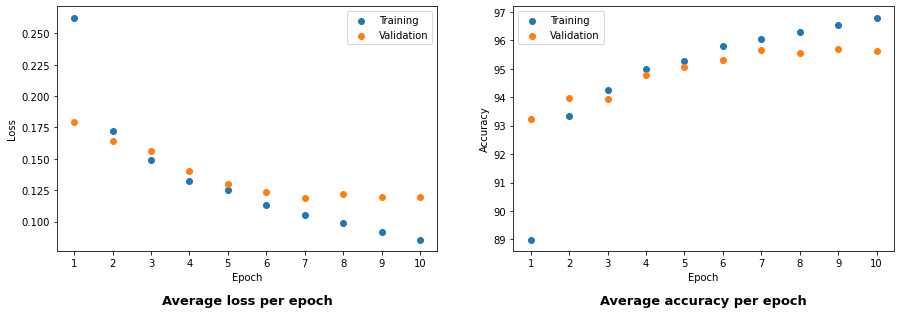

In [17]:
plot_metrics(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

In [72]:
# Evaluate:
loss, acc = test(model_task_one, val_dataloader, loss_fn)
print('Loss on validation set: ' + str(loss) + '\tAccuracy on validation set: ' + str(acc))

Loss on validation set: 0.12061286921713762	Accuracy on validation set: 95.62


# 2. Implement fully convolutional face detector that uses the binary classifier
Use the trained binary classification model for face detection in bigger images.  

In [18]:
class FullyConvolutionalDetector:
    def __init__(self, model, max_res=1024, scales=[1.0, 0.8, 0.6, 0.4, 0.2, 0.1], threshold=0.5):
        self.model = model
        self.max_res = max_res
        self.scales = scales
        self.threshold = threshold
    
    @torch.no_grad()
    def detect_single_scale(self, image):
        '''Run a fully convolutional model on the input image'''
        '''Image is assumed to be of shape HxWx3 and scaled to [0,1]'''
        face_coordinates, face_probabilities = [], []

        ## TODO
        ## Preprocess the image (subtract and divide as in training)
        pass

        ## Convert the image to a tensor of shape 1x3xHxW; move it to the same device as the model
        # image.size(0): Channel, image.size(1): Height, image.size(2): Width
        # following line is when input is not a tensor
        #image = torch.tensor(image)
        image = image.view(1, image.size(0), image.size(1), image.size(2))
        image = image.to(device)

        ## Run the self.model on the image
        output = self.model(image)

        ## Process the output with softmax (torch.softmax) on the channel dimension
        # As seen above model output is 1xCxHxW -> channel in second (index 1):
        output = torch.softmax(output, 1)

        ## Get probabilities for the face class (discard the non-face class)
        output = output.cpu().detach() # if not done TypeError occurs.. has to do with memory sth
        # just taking output values for HxW:
        output = output[0,1].numpy()

        ## Find output coordinates where the face probability > self.threshold
        ## (hint: you can convert output to numpy and use np.where)
        # indices where threshold is surpassed:
        coord_where_threshold_fulfilled = np.where(output>self.threshold)
        # now get (y,x) coords (because HxW):  
        coordinates = np.stack(coord_where_threshold_fulfilled, axis=1)

        ## Convert selected output coordinates to input coordinates 
        ## Return coordinates as a numpy array of shape Nx4 (N - detected faces)
        ## each row are coordinates x1, y1, x2, y2 - top left and bottom right corner of a rectangle
        # ratio_input_output = (in.width/in.height) / (out.width/out.height)
        ratio_in_out = (image.shape[3]/image.shape[2])/(output.shape[1]/output.shape[0])

        for (y_coord, x_coord) in coordinates:
          # 8: stride
          # getting face coordinates
          face_coords = (x_coord*8, y_coord*8, x_coord*8+48, y_coord*8+int(47/ratio_in_out))
          face_coordinates.append(face_coords)
          # getting face probability
          face_prob = output[y_coord, x_coord]
          face_probabilities.append(face_prob)

        ## Return face coordinates and their probabilities
        return face_coordinates, face_probabilities
    
    @torch.no_grad()
    def detect_multi_scale(self, image, nms=True):
        '''Run the detector on a pyramid of images (same image in different scales)'''
        all_face_coordinates = []
        all_face_probabilities = []
        for scale in self.scales:
            H, W, C = image.shape
            scale_factor = float(self.max_res) / max(H, W) * scale
            
            ## Resize the image by scale_factor (e.g. cv2.resize, convert to PIL.Image and resize...)
            # Caution: Casting to int is necessary
            resize_scale = (int(scale_factor*H), int(scale_factor*W))
            # For me it is easier to work with tensors therefore transform to one and resize in one step
            transforms = Compose([ToTensor(), Resize(resize_scale)])
            image_resized = transforms(image)
            
            ## Run detect_single_scale on resized image
            face_boxes, face_probabilities = self.detect_single_scale(image_resized)

            ## Scale back the returned face coordinates to original image coordinates
            face_boxes = np.array(face_boxes)/scale_factor

            ## Append detected face coordinates and probabilities to all_face_coordinates and probabilities
            # only add if bigger than zero (doesn't work if not done..)
            if len(face_probabilities)>0:
              all_face_coordinates.append(face_boxes)
              all_face_probabilities.append(face_probabilities)

        all_face_coordinates = np.concatenate(all_face_coordinates, 0)
        all_face_probabilities = np.concatenate(all_face_probabilities)
        if nms==True and len(all_face_coordinates) > 0: # merge overlapping predictions
            results = np.concatenate((all_face_coordinates, all_face_probabilities.reshape(-1,1)),1)
            results = nmsp(results, 0.3) 
            all_face_coordinates = results[:,:4]
            all_face_probabilities = results[:,4]
        return all_face_coordinates, all_face_probabilities

In [19]:
def read_images(img_dir, box_dir):
    # Returns a list of numpy array with images from img_dir scaled from [0, 1]
    # and a list of face bounding boxes (coordinates) for each image
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    box_files = [os.path.join(box_dir, f.replace('.jpg','.txt')) for f in img_files]
    img_files = [os.path.join(img_dir, f) for f in img_files]
    
    images = [np.array(Image.open(f)).astype(np.float32)/255 for f in img_files]
    boxes = [np.loadtxt(f, ndmin=2).astype(np.int32) for f in box_files]
    return images, boxes

def draw_boxes_with_gt(image, boxes, gt_boxes=None):
    img_draw = image.copy()
    for box in boxes:
        cv2.rectangle(img_draw,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0),
                      2)
    if gt_boxes is not None:
        for box in gt_boxes:
            cv2.rectangle(img_draw,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0,1,0),
                          2)
    plt.figure(figsize=(12,6))
    plt.imshow(img_draw)

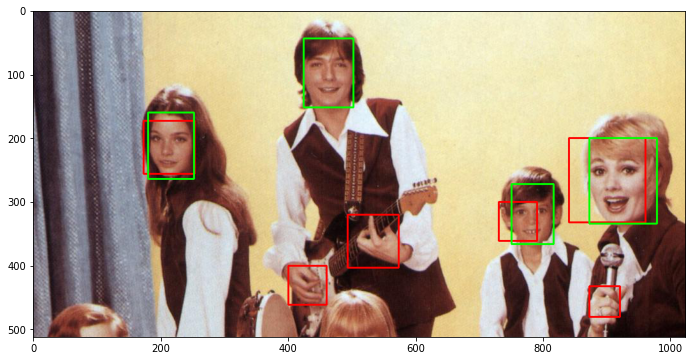

In [195]:
# Run evaluation on images from full_images folder

# Jupyter notebook local directories:
#full_imgs_dir = './Assignment2_data/full_images'
#full_boxes_dir = './Assignment2_data/full_boxes'

# Google colab directories:
full_imgs_dir = '/content/data/Assignment2_data/full_images/'
full_boxes_dir = '/content/data/Assignment2_data/full_boxes/'


images, true_face_boxes = read_images(full_imgs_dir, full_boxes_dir)
i = 3 # denotes which image to take
i_th_image, i_th_true_face_boxes = images[i], true_face_boxes[i]

detector = FullyConvolutionalDetector(model=model_task_one, threshold=0.998)

face_boxes, face_probs = detector.detect_multi_scale(i_th_image)
draw_boxes_with_gt(i_th_image, face_boxes, i_th_true_face_boxes)

# i = 0 best threshold: 0.999
# i = 1 best threshold: 0.999
# i = 2 best threshold: 0.9999
# i = 3 best threshold: 0.997
# taking a "medium", fitting value: threshold = 0.998

### Chosen threshold value: 0.998

### Now plotting all four images each once with nms=False and nms=True
I saw that when putting nms=False, an error is thrown and no image is plotted and therefore I put these commands in comments..

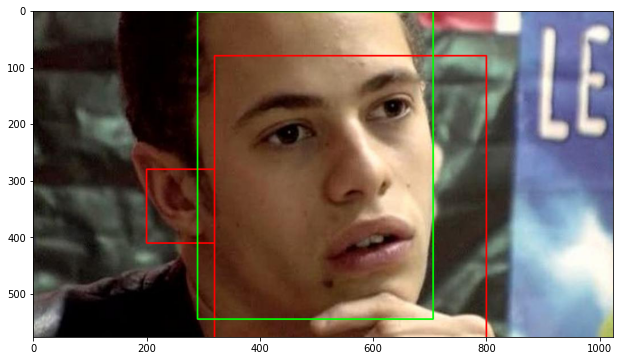

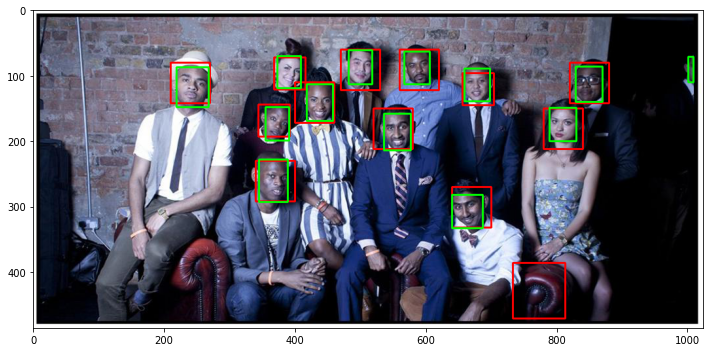

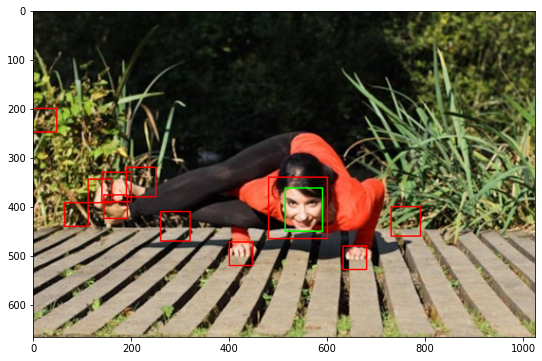

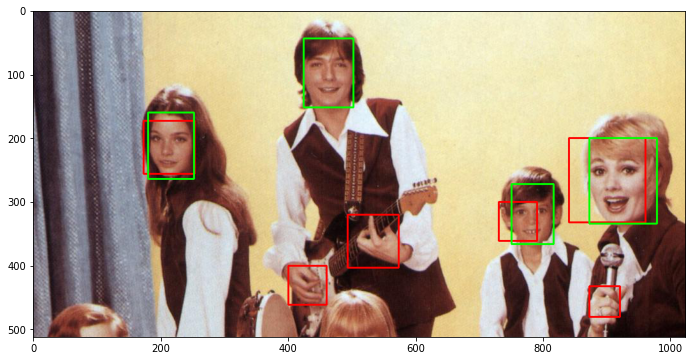

In [161]:
image_one, true_face_boxes_one = images[0], true_face_boxes[0]
image_two, true_face_boxes_two = images[1], true_face_boxes[1]
image_three, true_face_boxes_three = images[2], true_face_boxes[2]
image_four, true_face_boxes_four = images[3], true_face_boxes[3]

# 1, nms=True
face_boxes_one_t, face_probs_one_t = detector.detect_multi_scale(image_one)
draw_boxes_with_gt(image_one, face_boxes_one_t, true_face_boxes_one)

# 1, nms=False
# throws an error with nms = False and therefore I put these commands in comments
#face_boxes_one_f, face_probs_one_f = detector.detect_multi_scale(image_one, nms=False)
#draw_boxes_with_gt(image_one, face_boxes_one_f, true_face_boxes_one)


# 2, nms=True
face_boxes_two_t, face_probs_two_t = detector.detect_multi_scale(image_two)
draw_boxes_with_gt(image_two, face_boxes_two_t, true_face_boxes_two)

# 2, nms=False
#face_boxes_two_f, face_probs_two_f = detector.detect_multi_scale(image_two, nms=False)
#draw_boxes_with_gt(image_two, face_boxes_two_f, true_face_boxes_two)


# 3, nms=True
face_boxes_three_t, face_probs_three_t = detector.detect_multi_scale(image_three)
draw_boxes_with_gt(image_three, face_boxes_three_t, true_face_boxes_three)

# 3, nms=False
#face_boxes_three_f, face_probs_three_f = detector.detect_multi_scale(image_three, nms=False)
#draw_boxes_with_gt(image_three, face_boxes_three_f, true_face_boxes_three)


# 4, nms=True
face_boxes_four_t, face_probs_four_t = detector.detect_multi_scale(image_four)
draw_boxes_with_gt(image_four, face_boxes_four_t, true_face_boxes_four)

# 4, nms=False
#face_boxes_four_f, face_probs_four_f = detector.detect_multi_scale(image_four, nms=False)
#draw_boxes_with_gt(image_four, face_boxes_four_f, true_face_boxes_four)

# 3. Improve the model
Propose different improvements and train new models (follow instructions from the pdf)

I defined the following five different models:

(1) Model_with_droupout

(2) Model_with_dropout_sigmoid_activation

(3) Model_with_batch_normalization

(4) Model_with_dropout_batch_normalization

(5) Model_dropout_batchnorm_changed_params

## Model 1: Dropout function after activation function

In this model the architecture is changed comparing to the model from the first task. The other parameters stay the same. The change consists of additional dropout layers in the architecture.

Dropout was used after the activation function of each convolutional layer: CONV->ACTIVATION->DROPOUT with a low default value of 0.2.

In [60]:
class Model_with_dropout(nn.Module):
    
    def __init__(self, dropout_parameter=0.2):
        super(Model_with_dropout, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1)),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), ceil_mode=True),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            # 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(1,1)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=(1,1), stride=(1,1))
        )
        
    def forward(self, x):
        # as seen in tutorial:
        # no flattening here, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = self.conv_layers(x)
        # output = output.view(output.size(0), 2*1*1)
        return output

In [61]:
model_3_1 = Model_with_dropout()
model_3_1 = model_3_1.to(device)
learning_rate_3_1 = 0.0003
optimizer_3_1 = torch.optim.Adam(model_3_1.parameters(), lr=learning_rate_3_1)
n_epochs_3_1 = 10
loss_fn_3_1 = nn.CrossEntropyLoss()

In [62]:
train_losses_3_1, train_accuracies_3_1, val_losses_3_1, val_accuracies_3_1 = fit(model_3_1, train_dataloader, val_dataloader, optimizer_3_1, loss_fn_3_1, n_epochs_3_1)

Epoch 1/10: train_loss: 0.3083, train_accuracy: 86.9857, val_loss: 0.1946, val_accuracy: 92.5300
Epoch 2/10: train_loss: 0.2026, train_accuracy: 92.1536, val_loss: 0.1600, val_accuracy: 93.8100
Epoch 3/10: train_loss: 0.1792, train_accuracy: 93.0815, val_loss: 0.1503, val_accuracy: 94.4600
Epoch 4/10: train_loss: 0.1651, train_accuracy: 93.7687, val_loss: 0.1365, val_accuracy: 94.8400
Epoch 5/10: train_loss: 0.1557, train_accuracy: 94.0844, val_loss: 0.1512, val_accuracy: 94.1800
Epoch 6/10: train_loss: 0.1477, train_accuracy: 94.4762, val_loss: 0.1289, val_accuracy: 95.1400
Epoch 7/10: train_loss: 0.1415, train_accuracy: 94.7325, val_loss: 0.1311, val_accuracy: 95.0200
Epoch 8/10: train_loss: 0.1368, train_accuracy: 94.9474, val_loss: 0.1222, val_accuracy: 95.7000
Epoch 9/10: train_loss: 0.1350, train_accuracy: 94.9407, val_loss: 0.1202, val_accuracy: 95.5100
Epoch 10/10: train_loss: 0.1320, train_accuracy: 95.0918, val_loss: 0.1230, val_accuracy: 95.3800


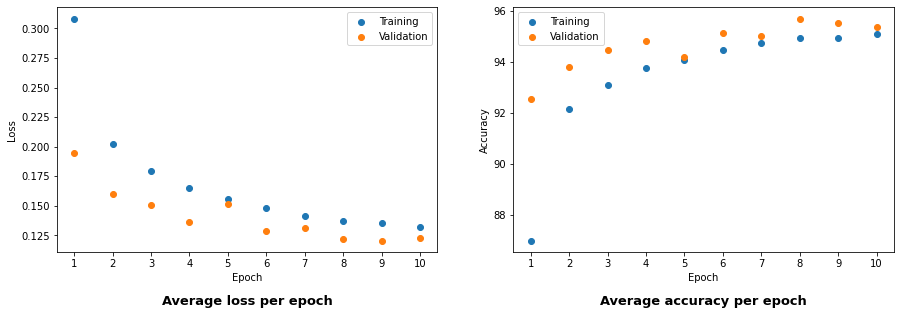

In [63]:
plot_metrics(n_epochs_3_1, train_losses_3_1, val_losses_3_1, train_accuracies_3_1, val_accuracies_3_1)

In [71]:
# Evaluate:
loss_3_1, acc_3_1 = test(model_3_1, val_dataloader, loss_fn_3_1)
print('Loss on validation set: ' + str(loss_3_1) + '\tAccuracy on validation set: ' + str(acc_3_1))

Loss on validation set: 0.12461428095106107	Accuracy on validation set: 95.38


## Model 2: Dropout function and another activation function

In this model I changed the activation function in the layers of the architecture of the network from LeakyReLU as previous to the Sigmoid function and I kept the dropout function after the activation function. In contrast with the previous model now the dropout probability is increased up to 0.4.

In [68]:
class Model_with_dropout_sigmoid_activation(nn.Module):
    
    def __init__(self, dropout_parameter=0.2):
        super(Model_with_dropout_sigmoid_activation, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1)),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), ceil_mode=True),
            nn.Sigmoid(),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Sigmoid(),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Sigmoid(),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(1,1)),
            nn.Sigmoid(),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1)),
            nn.Sigmoid(),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=(1,1), stride=(1,1))
        )
        
    def forward(self, x):
        # as seen in tutorial:
        # no flattening here, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = self.conv_layers(x)
        # output = output.view(output.size(0), 2*1*1)
        return output

In [69]:
model_3_2 = Model_with_dropout_sigmoid_activation(dropout_parameter=0.4)
model_3_2 = model_3_2.to(device)
learning_rate_3_2 = 0.0003
optimizer_3_2 = torch.optim.Adam(model_3_2.parameters(), lr=learning_rate_3_2)
n_epochs_3_2 = 10
loss_fn_3_2 = nn.CrossEntropyLoss()

In [70]:
train_losses_3_2, train_accuracies_3_2, val_losses_3_2, val_accuracies_3_2 = fit(model_3_2, train_dataloader, val_dataloader, optimizer_3_2, loss_fn_3_2, n_epochs_3_2)

Epoch 1/10: train_loss: 0.6856, train_accuracy: 53.5919, val_loss: 0.5778, val_accuracy: 75.2600
Epoch 2/10: train_loss: 0.5826, train_accuracy: 70.3750, val_loss: 0.4880, val_accuracy: 78.1100
Epoch 3/10: train_loss: 0.4781, train_accuracy: 78.5046, val_loss: 0.3980, val_accuracy: 82.8100
Epoch 4/10: train_loss: 0.4218, train_accuracy: 81.6342, val_loss: 0.3639, val_accuracy: 85.0300
Epoch 5/10: train_loss: 0.3945, train_accuracy: 83.0121, val_loss: 0.3515, val_accuracy: 85.5500
Epoch 6/10: train_loss: 0.3792, train_accuracy: 83.7967, val_loss: 0.3310, val_accuracy: 86.3900
Epoch 7/10: train_loss: 0.3670, train_accuracy: 84.3038, val_loss: 0.3174, val_accuracy: 86.7700
Epoch 8/10: train_loss: 0.3534, train_accuracy: 84.8858, val_loss: 0.3055, val_accuracy: 87.1200
Epoch 9/10: train_loss: 0.3436, train_accuracy: 85.4824, val_loss: 0.2972, val_accuracy: 87.4000
Epoch 10/10: train_loss: 0.3330, train_accuracy: 85.9772, val_loss: 0.2895, val_accuracy: 87.6900


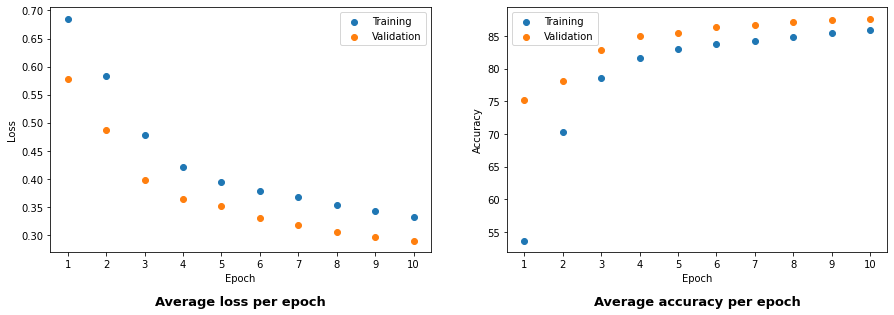

In [73]:
plot_metrics(n_epochs_3_2, train_losses_3_2, val_losses_3_2, train_accuracies_3_2, val_accuracies_3_2)

In [93]:
# Evaluate:
loss_3_2, acc_3_2 = test(model_3_2, val_dataloader, loss_fn_3_2)
print('Loss on validation set: ' + str(loss_3_2) + '\tAccuracy on validation set: ' + str(acc_3_2))

Loss on validation set: 0.2880317035374368	Accuracy on validation set: 87.69


## Model 3: Batch normalization is applied several times

In this model I used batch normalization in the architecture of the CNN applied after the convolutional layers.

In [90]:
class Model_with_batch_normalization(nn.Module):
    
    def __init__(self):
        super(Model_with_batch_normalization, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), ceil_mode=True),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features=2)
        )
        
    def forward(self, x):
        # as seen in tutorial:
        # no flattening here, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = self.conv_layers(x)
        # output = output.view(output.size(0), 2*1*1)
        return output

In [91]:
model_3_3 = Model_with_batch_normalization()
model_3_3 = model_3_3.to(device)
learning_rate_3_3 = 0.0003
optimizer_3_3 = torch.optim.Adam(model_3_3.parameters(), lr=learning_rate_3_3)
n_epochs_3_3 = 10
loss_fn_3_3 = nn.CrossEntropyLoss()

In [92]:
train_losses_3_3, train_accuracies_3_3, val_losses_3_3, val_accuracies_3_3 = fit(model_3_3, train_dataloader, val_dataloader, optimizer_3_3, loss_fn_3_3, n_epochs_3_3)

Epoch 1/10: train_loss: 0.2374, train_accuracy: 91.7585, val_loss: 0.1809, val_accuracy: 94.0700
Epoch 2/10: train_loss: 0.1723, train_accuracy: 94.0833, val_loss: 0.1543, val_accuracy: 94.9300
Epoch 3/10: train_loss: 0.1440, train_accuracy: 94.9631, val_loss: 0.1399, val_accuracy: 95.2600
Epoch 4/10: train_loss: 0.1276, train_accuracy: 95.4533, val_loss: 0.1249, val_accuracy: 95.8800
Epoch 5/10: train_loss: 0.1160, train_accuracy: 95.8272, val_loss: 0.1359, val_accuracy: 95.0400
Epoch 6/10: train_loss: 0.1059, train_accuracy: 96.1417, val_loss: 0.1181, val_accuracy: 95.8100
Epoch 7/10: train_loss: 0.0980, train_accuracy: 96.3980, val_loss: 0.1231, val_accuracy: 95.8800
Epoch 8/10: train_loss: 0.0889, train_accuracy: 96.7685, val_loss: 0.1170, val_accuracy: 95.9200
Epoch 9/10: train_loss: 0.0834, train_accuracy: 96.9319, val_loss: 0.1356, val_accuracy: 95.1000
Epoch 10/10: train_loss: 0.0761, train_accuracy: 97.2308, val_loss: 0.1213, val_accuracy: 95.9300


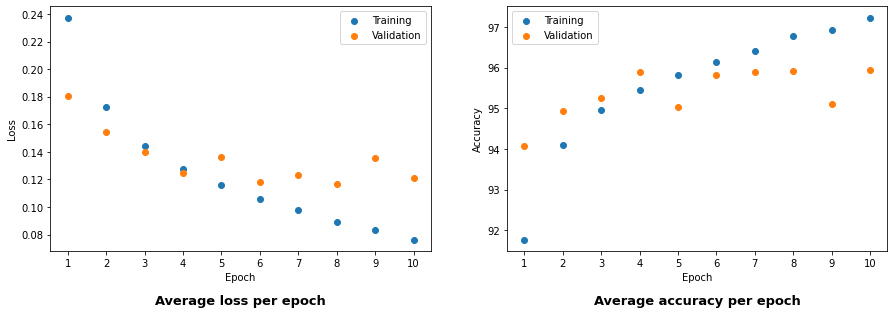

In [94]:
plot_metrics(n_epochs_3_3, train_losses_3_3, val_losses_3_3, train_accuracies_3_3, val_accuracies_3_3)

In [95]:
# Evaluate:
loss_3_3, acc_3_3 = test(model_3_3, val_dataloader, loss_fn_3_3)
print('Loss on validation set: ' + str(loss_3_3) + '\tAccuracy on validation set: ' + str(acc_3_3))

Loss on validation set: 0.12249111492115601	Accuracy on validation set: 95.93


## Model 4: Dropout function and batch normalization

For this approach I combine two previously done changes onto the model: I have a batch normalization after each convolutional layer and a dropout function directly after each activation function.

In [97]:
class Model_with_dropout_batch_normalization(nn.Module):
    
    def __init__(self, dropout_parameter=0.2):
        super(Model_with_dropout_batch_normalization, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), ceil_mode=True),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            # 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_parameter),
            #
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features=2)
        )
        
    def forward(self, x):
        # as seen in tutorial:
        # no flattening here, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = self.conv_layers(x)
        # output = output.view(output.size(0), 2*1*1)
        return output

In [98]:
model_3_4 = Model_with_dropout_batch_normalization()
model_3_4 = model_3_4.to(device)
learning_rate_3_4 = 0.0003
optimizer_3_4 = torch.optim.Adam(model_3_4.parameters(), lr=learning_rate_3_4)
n_epochs_3_4 = 10
loss_fn_3_4 = nn.CrossEntropyLoss()

In [99]:
train_losses_3_4, train_accuracies_3_4, val_losses_3_4, val_accuracies_3_4 = fit(model_3_4, train_dataloader, val_dataloader, optimizer_3_4, loss_fn_3_4, n_epochs_3_4)

Epoch 1/10: train_loss: 0.2966, train_accuracy: 88.3759, val_loss: 0.2007, val_accuracy: 92.6500
Epoch 2/10: train_loss: 0.2240, train_accuracy: 91.5536, val_loss: 0.1742, val_accuracy: 93.5100
Epoch 3/10: train_loss: 0.2008, train_accuracy: 92.3931, val_loss: 0.1591, val_accuracy: 94.1100
Epoch 4/10: train_loss: 0.1847, train_accuracy: 92.9964, val_loss: 0.1442, val_accuracy: 94.6500
Epoch 5/10: train_loss: 0.1763, train_accuracy: 93.2449, val_loss: 0.1446, val_accuracy: 94.6400
Epoch 6/10: train_loss: 0.1692, train_accuracy: 93.5259, val_loss: 0.1298, val_accuracy: 95.1600
Epoch 7/10: train_loss: 0.1642, train_accuracy: 93.7743, val_loss: 0.1311, val_accuracy: 95.2700
Epoch 8/10: train_loss: 0.1565, train_accuracy: 93.9937, val_loss: 0.1276, val_accuracy: 95.2100
Epoch 9/10: train_loss: 0.1539, train_accuracy: 94.1863, val_loss: 0.1265, val_accuracy: 95.2800
Epoch 10/10: train_loss: 0.1487, train_accuracy: 94.3340, val_loss: 0.1198, val_accuracy: 95.7300


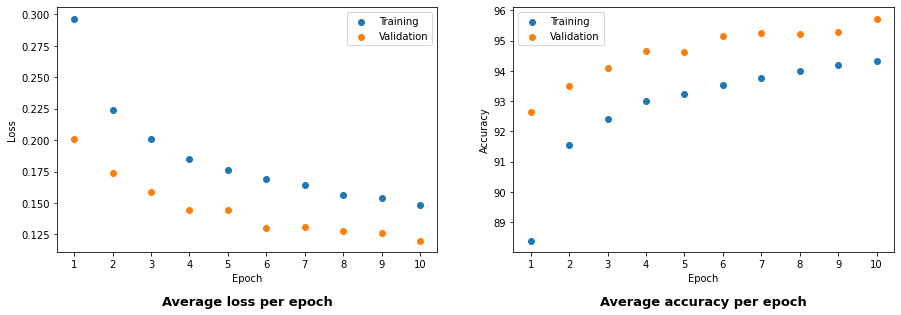

In [100]:
plot_metrics(n_epochs_3_4, train_losses_3_4, val_losses_3_4, train_accuracies_3_4, val_accuracies_3_4)

In [101]:
# Evaluate:
loss_3_4, acc_3_4 = test(model_3_4, val_dataloader, loss_fn_3_4)
print('Loss on validation set: ' + str(loss_3_4) + '\tAccuracy on validation set: ' + str(acc_3_4))

Loss on validation set: 0.12025440306325627	Accuracy on validation set: 95.73


## Model 5: Dropout function, batch normalization and changed paramters

For this approach the previous fourth model is taken into consideration but different parameters are changed such as the dropout probability (from default 0.2 to 0.1) and the learning rate (from 0.0003 to 0.003).

In [102]:
model_3_5 = Model_with_dropout_batch_normalization(dropout_parameter=0.1)
model_3_5 = model_3_5.to(device)
learning_rate_3_5 = 0.003
optimizer_3_5 = torch.optim.Adam(model_3_5.parameters(), lr=learning_rate_3_5)
n_epochs_3_5 = 10
loss_fn_3_5 = nn.CrossEntropyLoss()

In [103]:
train_losses_3_5, train_accuracies_3_5, val_losses_3_5, val_accuracies_3_5 = fit(model_3_5, train_dataloader, val_dataloader, optimizer_3_5, loss_fn_3_5, n_epochs_3_5)

Epoch 1/10: train_loss: 0.2435, train_accuracy: 90.1612, val_loss: 0.1811, val_accuracy: 93.3200
Epoch 2/10: train_loss: 0.1822, train_accuracy: 92.9304, val_loss: 0.1424, val_accuracy: 94.7700
Epoch 3/10: train_loss: 0.1620, train_accuracy: 93.7967, val_loss: 0.1374, val_accuracy: 94.8900
Epoch 4/10: train_loss: 0.1540, train_accuracy: 94.1448, val_loss: 0.1499, val_accuracy: 94.1700
Epoch 5/10: train_loss: 0.1431, train_accuracy: 94.5232, val_loss: 0.1393, val_accuracy: 94.8700
Epoch 6/10: train_loss: 0.1353, train_accuracy: 94.9138, val_loss: 0.1206, val_accuracy: 95.2800
Epoch 7/10: train_loss: 0.1310, train_accuracy: 95.1030, val_loss: 0.1245, val_accuracy: 95.1400
Epoch 8/10: train_loss: 0.1249, train_accuracy: 95.2765, val_loss: 0.1430, val_accuracy: 94.3800
Epoch 9/10: train_loss: 0.1202, train_accuracy: 95.5238, val_loss: 0.1206, val_accuracy: 95.4800
Epoch 10/10: train_loss: 0.1175, train_accuracy: 95.5798, val_loss: 0.1097, val_accuracy: 95.9100


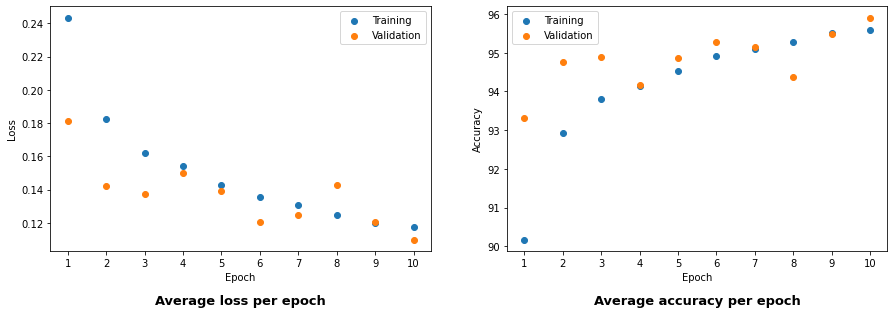

In [104]:
plot_metrics(n_epochs_3_5, train_losses_3_5, val_losses_3_5, train_accuracies_3_5, val_accuracies_3_5)

In [105]:
# Evaluate:
loss_3_5, acc_3_5 = test(model_3_5, val_dataloader, loss_fn_3_5)
print('Loss on validation set: ' + str(loss_3_5) + '\tAccuracy on validation set: ' + str(acc_3_5))

Loss on validation set: 0.10976707166547228	Accuracy on validation set: 95.91


## Analysis from the five different models
Classification accuracy on the validation set for each model:

Model 0: 95.62 (Task 1)

Model 1: 95.38

Model 2: 87.69

Model 3: 95.93

Model 4: 95.73

Model 5: 95.91

Continuing with the best model (Model 3) and running the multiscale detection on the 4 full images and one image of my choice.

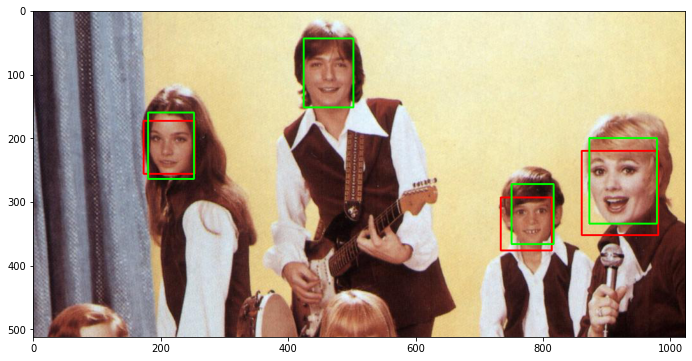

In [196]:
i = 3 # denotes which image to take
i_th_image, i_th_true_face_boxes = images[i], true_face_boxes[i]

detector_2 = FullyConvolutionalDetector(model=model_3_3, threshold=0.996)

face_boxes, face_probs = detector_2.detect_multi_scale(i_th_image)
draw_boxes_with_gt(i_th_image, face_boxes, i_th_true_face_boxes)

# i = 0 best threshold: 0.998
# i = 1 best threshold: 0.998
# i = 2 best threshold: 0.999
# i = 3 best threshold: 0.996
# taking a "medium", fitting value: threshold = 0.996

It's always a trade-off, as before. Especially the third picture (yoga) and the fourth (music band) are contradicting it seems to me. Once one gets a good score of False Positives and True Positives then the other gets worse. The chosen threshold laid more focus on the music band picture.

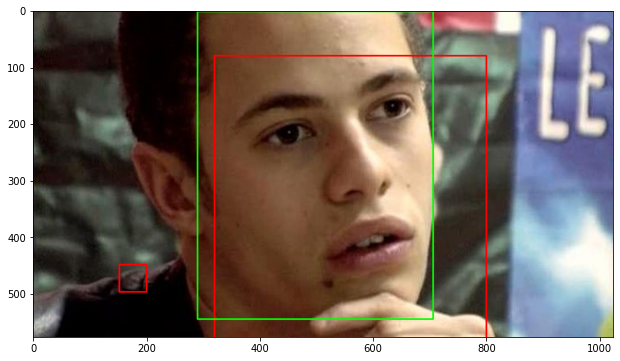

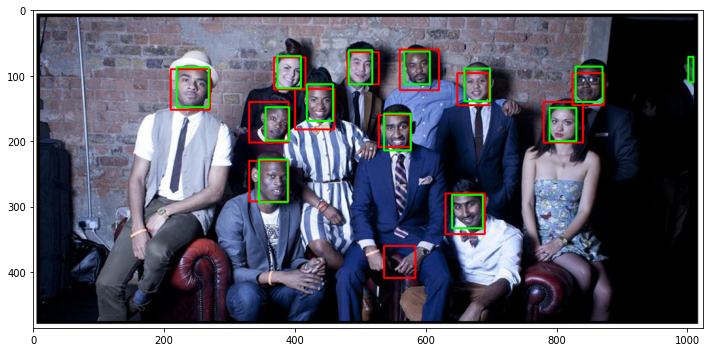

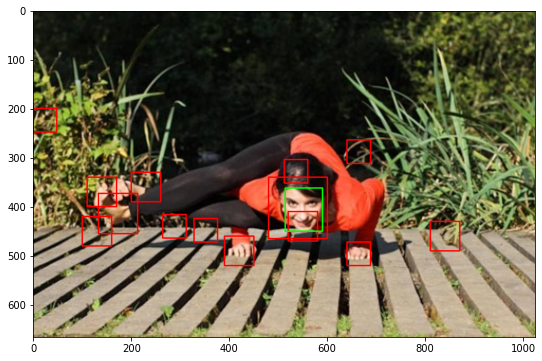

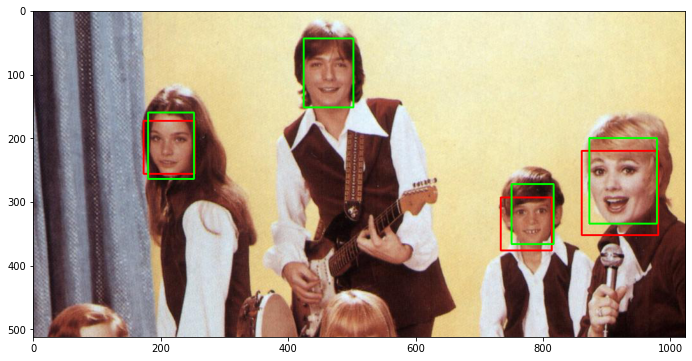

In [157]:
image_one, true_face_boxes_one = images[0], true_face_boxes[0]
image_two, true_face_boxes_two = images[1], true_face_boxes[1]
image_three, true_face_boxes_three = images[2], true_face_boxes[2]
image_four, true_face_boxes_four = images[3], true_face_boxes[3]

face_boxes_1, face_probs_1 = detector_2.detect_multi_scale(image_one)
draw_boxes_with_gt(image_one, face_boxes_1, true_face_boxes_one)

face_boxes_2, face_probs_2 = detector_2.detect_multi_scale(image_two)
draw_boxes_with_gt(image_two, face_boxes_2, true_face_boxes_two)

face_boxes_3, face_probs_3 = detector_2.detect_multi_scale(image_three)
draw_boxes_with_gt(image_three, face_boxes_3, true_face_boxes_three)

face_boxes_4, face_probs_4 = detector_2.detect_multi_scale(image_four)
draw_boxes_with_gt(image_four, face_boxes_4, true_face_boxes_four)

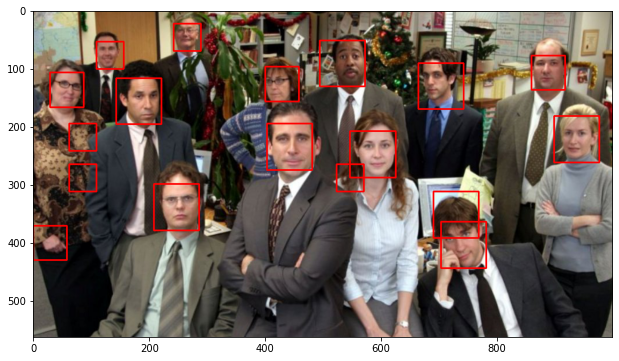

In [189]:
# now plotting an image of my choice: The Office (Series)

test_image, test_true_box = read_images('/content/test_image/image/', '/content/test_image/box/') 
test_img, test_tb = test_image[0], test_true_box[0]

test_face_boxes, test_face_probs = detector_2.detect_multi_scale(test_img)
draw_boxes_with_gt(test_img, test_face_boxes, test_tb)